In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.dummy import DummyClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics # # from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
# from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import modelEvalUtils as meu

# %config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
base_df = pd.read_csv("../Data/clinvar_conflicting.csv", dtype={"CHROM": "string", "MOTIF_NAME": "string", "HIGH_INF_POS": "string"})

In [3]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  string 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [4]:
# reduce the data frame and do some basic cleaning, start with just a few bare features

# features to test first:
#     - CHROM, REF, ALT, AF_*, CLNVC, ORIGIN, CLASS, Allele, Consequence, IMPACT, STRAND

# features which don't seem to be super useful (maybe they would be when all together)
# CHROM, REF, ALT, CLNVC, ORIGIN, Consequence, IMPACT (seems like this should be at a least a little useful), STRAND

# select features

target_var = ['CLASS']
# other_features = ['CHROM']
# categorical_features = ['REF', 'ALT']
other_features = []
categorical_features = ['CHROM', 'REF', 'ALT']
numeric_features = ['CADD_PHRED']

reduced_df = base_df[target_var + other_features + categorical_features + numeric_features]

# feature cleaing/adjustment below here

# drop nulls
reduced_df.dropna(inplace=True)

# CHROM - turn CHROM strings into numbers
# reduced_df.loc[reduced_df['CHROM'] == 'X', 'CHROM'] = '23'
# reduced_df.loc[reduced_df['CHROM'] == 'MT', 'CHROM'] = '24'
# reduced_df["CHROM"] = pd.to_numeric(reduced_df["CHROM"])

    # dropping MT rows (after it was converted to 24)
    # reduced_df.drop(reduced_df[reduced_df['CHROM'] == 24].index, inplace=True)

# REF, ALT - lots of alleles with more than one type, combine them all as "2+" instead of dropping them like below
reduced_df.loc[reduced_df['REF'].str.len() > 1, 'REF'] = '2+'
reduced_df.loc[reduced_df['ALT'].str.len() > 1, 'ALT'] = '2+'
# reduced_df['REF'] = reduced_df['REF'].astype(str)
# reduced_df['ALT'] = reduced_df['ALT'].astype(str)

    # drop rows where REF is not one of the main 4 (for others there are not many rows, could maybe combine them though in the future somehow)
    # main_alleles = ['C', 'G', 'A', 'T']
    # reduced_df = reduced_df[reduced_df['REF'].isin(main_alleles)]

# ORIGIN - combine ORIGIN values if they are more than 1 (too many of them, and they are a sum of the smaller parts, making it difficult to split them out - could try and do that though)
# reduced_df['ORIGIN'] = reduced_df['ORIGIN'].astype(str)
# reduced_df.loc[reduced_df['ORIGIN'] != '1', 'ORIGIN'] = '1+'
    # try dropping most common one to see if there are any trends for the lesser count categories
    # reduced_df.drop(reduced_df[reduced_df['ORIGIN'] == 1].index, inplace=True)

# Consequence - drop those with less than 100 counts
# reduced_df = reduced_df.groupby('Consequence').filter(lambda x : len(x)>100)

# print('Column type:', type(reduced_df.iloc[0][test_var]))
# print('Num categores:', reduced_df[test_var].nunique())
# with pd.option_context('display.max_rows', 20000):
#     print(reduced_df[test_var].value_counts())


# print(reduced_df['CLASS'].unique())
# print(reduced_df['CLASS'].value_counts())

reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64096 entries, 0 to 65187
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CLASS       64096 non-null  int64  
 1   CHROM       64096 non-null  string 
 2   REF         64096 non-null  object 
 3   ALT         64096 non-null  object 
 4   CADD_PHRED  64096 non-null  float64
dtypes: float64(1), int64(1), object(2), string(1)
memory usage: 2.9+ MB


<ipython-input-4-7c45b7ea8a38>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df.dropna(inplace=True)
/Users/NickPC/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/NickPC/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [5]:
# check categorical variables vs conflicting or not to try and find some predictive features - do this before encoding so there are less plots to make
# for col in reduced_df.columns:
#     if(col == 'CLASS' or col == 'CADD_PHRED'): continue
#     plt.figure()
#     counts = (reduced_df.groupby(['CLASS'])[col]
#                      .value_counts(normalize=True)
#                      .rename('percentage')
#                      .mul(100)
#                      .reset_index()
#                      .sort_values(col))
#     sns.barplot(x=col, y="percentage", hue="CLASS", data=counts)


In [6]:
# sns.scatterplot(df_train, corner=True, height=1.5, plot_kws={'size': 3}, hue='CLASS');

In [7]:
# columns_to_encode = list(reduced_df.columns)
# columns_to_encode.remove('CLASS')
# columns_to_encode.remove('CHROM')
# columns_to_encode.remove('CADD_PHRED')
# columns_to_encode

In [8]:
# encode REF column 
# encoded_df = pd.get_dummies(reduced_df, prefix=['CHROM', 'REF', 'ALT', test_var], columns=['CHROM', 'REF', 'ALT', test_var])
# encoded_df = pd.get_dummies(reduced_df, prefix=['REF', 'ALT', 'CLNVC', 'ORIGIN', 'Consequence'], columns=['REF', 'ALT', 'CLNVC', 'ORIGIN', 'Consequence'])
# encoded_df = pd.get_dummies(reduced_df, prefix=['REF', 'ALT', 'Consequence', test_var], columns=['REF', 'ALT', 'Consequence', test_var])
# encoded_df = pd.get_dummies(reduced_df, prefix=['REF', 'ALT', test_var], columns=['REF', 'ALT', test_var])
# encoded_df = pd.get_dummies(reduced_df, prefix=columns_to_encode, columns=columns_to_encode)
# encoded_df

In [9]:
# split data into test and train sets
# df_train, df_test = train_test_split(reduced_df, test_size=0.2, random_state=55)
# df_train, df_test = train_test_split(encoded_df, test_size=0.2, random_state=55)

In [10]:
# sns.pairplot(df_train, corner=True, height=1.5, plot_kws={'size': 3}, hue='CLASS');

In [11]:
# sns.kdeplot(df_train['CHROM'], hue=df_train['CLASS'])
# sns.kdeplot(df_train.loc[df_train['CLASS'] == 0, 'CHROM'], color='r')
# sns.kdeplot(df_train.loc[df_train['CLASS'] == 1, 'CHROM'], color='b')

In [12]:
# sns.countplot(df_train.loc[df_train['CLASS'] == 0, 'CHROM'], color='r')
# sns.countplot(df_train.loc[df_train['CLASS'] == 1, 'CHROM'], color='b')

In [13]:
# stop

In [14]:
# split out features and target for models

feature_data = reduced_df.drop('CLASS', axis=1)
target_data = reduced_df['CLASS']

feature_data.reset_index(inplace=True, drop=True)
target_data.reset_index(inplace=True, drop=True)

In [15]:

numeric_transformer = StandardScaler()
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

kNN_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)], 
    remainder='passthrough')

tree_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')


In [16]:
# various models
dummy_model = DummyClassifier(strategy="most_frequent")
knn_model = KNeighborsClassifier(n_neighbors=3)
dt_model = DecisionTreeClassifier(max_depth=4, random_state=121)
rf_model = RandomForestClassifier(n_estimators=10, random_state=121)

base_models = ["dummy_model", "knn_model"]
tree_models = ["dt_model", "rf_model"]

Current model is:  dummy_model


/Users/NickPC/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.85     38277
           1       0.00      0.00      0.00     12999

    accuracy                           0.75     51276
   macro avg       0.37      0.50      0.43     51276
weighted avg       0.56      0.75      0.64     51276



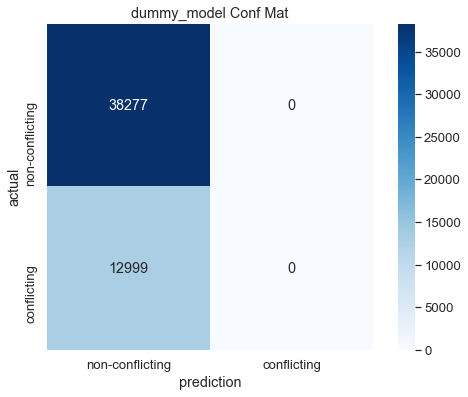

Current model is:  knn_model
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     38277
           1       0.68      0.44      0.53     12999

    accuracy                           0.80     51276
   macro avg       0.75      0.68      0.71     51276
weighted avg       0.79      0.80      0.79     51276



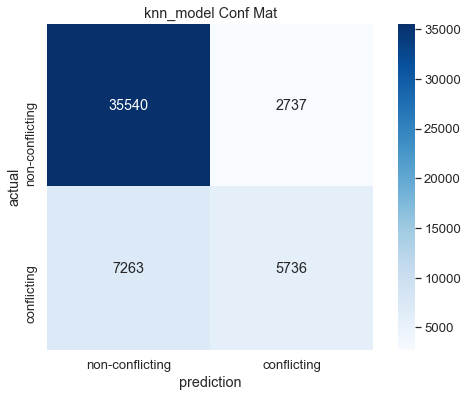

In [17]:
# run over base models
for model_name in base_models:
    print('Current model is: ', model_name)

    kNN_pipeline = Pipeline(steps=[('kNN_preprocessor', kNN_preprocessor),
                                   ('classifier', eval(model_name))])    
    
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.2, random_state=55)

    kNN_pipeline.fit(X_train, y_train)
    
    y_pred = kNN_pipeline.predict(X_train)
    
    meu.printMetricsAndConfMat(y_train, y_pred, model_name)
    

Current model is:  dt_model
              precision    recall  f1-score   support

           0       0.75      1.00      0.85     38277
           1       0.60      0.00      0.00     12999

    accuracy                           0.75     51276
   macro avg       0.67      0.50      0.43     51276
weighted avg       0.71      0.75      0.64     51276



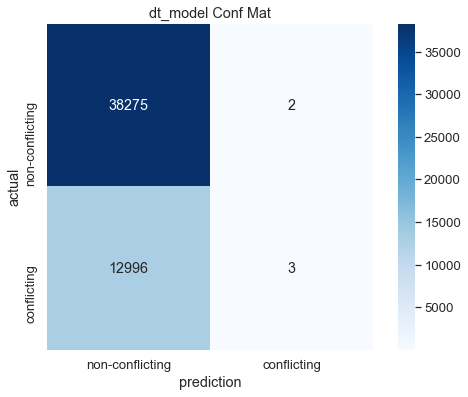

Current model is:  rf_model
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     38277
           1       0.89      0.70      0.79     12999

    accuracy                           0.90     51276
   macro avg       0.90      0.84      0.86     51276
weighted avg       0.90      0.90      0.90     51276



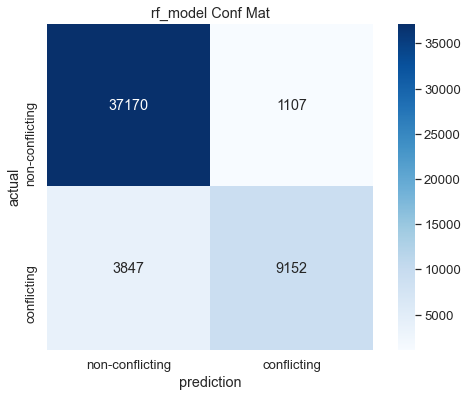

In [18]:
# run over tree models
for model_name in tree_models:
    print('Current model is: ', model_name)

    tree_pipeline = Pipeline(steps=[('tree_preprocessor', tree_preprocessor),
                                    ('classifier', eval(model_name))])  
    
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.2, random_state=55)
        
    tree_pipeline.fit(X_train, y_train)
        
    y_pred = tree_pipeline.predict(X_train)
    
    meu.printMetricsAndConfMat(y_train, y_pred, model_name)
    

In [19]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class DFChecker(BaseEstimator, TransformerMixin):
#     def __init__(self, numberCheck):
#         print('Calling init!', numberCheck, ' \n')
#         self.numberCheck = numberCheck
        
#     def fit(self, x, y = None):
#         print('Calling fit!', self.numberCheck, ' \n')
        
#         print(x.shape)
#         if(self.numberCheck == 1):
#             print(x.iloc[0])
#         else:
#             print(x[0])
        
#         return self
    
#     def transform(self, x, y = None):
#         print('Calling transform!', self.numberCheck, ' \n')
#         x_ = x.copy()
        
#         print(x_.shape)
#         if(self.numberCheck == 1):
#             print(x_.iloc[0])
#         else:
#             print(x_[0])
            
#         return x_

In [20]:
# some potentially relevant code for doing cross validation with many models 

# for i in test_range:
#     cv_out = cross_validate(
#         estimator=BaggingRegressor(DecisionTreeRegressor(random_state=123), 
#                                    n_estimators=i),
#         X=X_train,
#         y=y_train,
#         cv=3,
#         return_train_score=True,
#         scoring={
#             "variance": make_scorer(variance_metric),
#             "bias": make_scorer(bias_metric)
#         },
#         n_jobs=-1,  #Possible issues if sklearn.__version__ < 0.20.1; If error, switch to n_jobs=1
#     )
#     variance.append(np.mean(cv_out['test_variance']))
#     bias.append(np.mean(cv_out['test_bias']))